In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
#import xlwt
import csv, numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.mixture import GMM



In [2]:
# Training data
train_file  = open('train.csv', "r")
bike_train = csv.reader(train_file)

header_row = True
train_data, train_labels = [], []
for row in bike_train:
    # Save header row.
    if header_row:
        header = row
        header_row = False
    else:
        train_data.append(row)
        train_labels.append(header)

train_data = np.array(train_data)
train_labels = np.array(train_labels)
        
train_file.close()


# Test Data
test_file  = open('test.csv', "r")
bike_test = csv.reader(test_file)
header_row = True
test_data, test_labels = [], []
for row in bike_test:
    # Save header row.
    if header_row:
        header = row
        header_row = False
    else:
        test_data.append(row)
        test_labels.append(header)

test_data = np.array(test_data)
test_labels = np.array(test_labels)
        
test_file.close()

# Sanity checks
#print(train_data.shape)
#print(train_labels.shape)
#print (train_data[10])
#print (train_labels[10])

#print(test_data.shape)
#print(test_labels.shape)
#print (test_data[10])
#print (test_labels[10])

conv_train_data = np.zeros(train_data.shape)

for row in range(0, train_data.shape[0]):
    for col in range(1, train_data.shape[1]):
        conv_train_data[row, col] = train_data[row, col]
        

conv_test_data = np.zeros(test_data.shape)

for row in range(0, test_data.shape[0]):
    for col in range(1, test_data.shape[1]):
        conv_test_data[row, col] = test_data[row, col]
        
# For now remove to data and time
# Also remove the registered and causal columns
new_train_data = conv_train_data[:, 1:conv_train_data.shape[1]-3]
new_output_data = conv_train_data[:, conv_train_data.shape[1]-1]
new_test_data = conv_test_data[:, 1:conv_test_data.shape[1]]

new_train_labels = train_labels[:, 1:train_labels.shape[1]-3]
new_test_labels = test_labels[:, 1:test_labels.shape[1]]



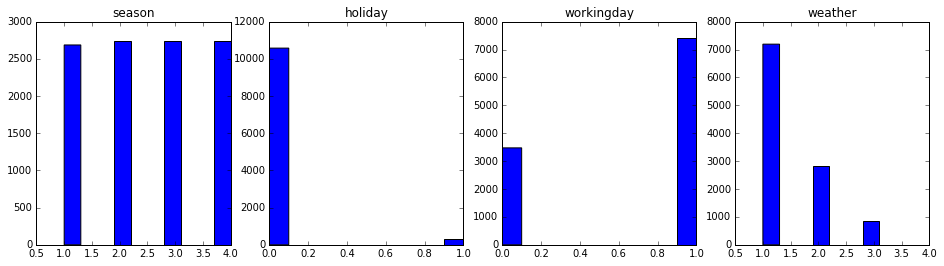

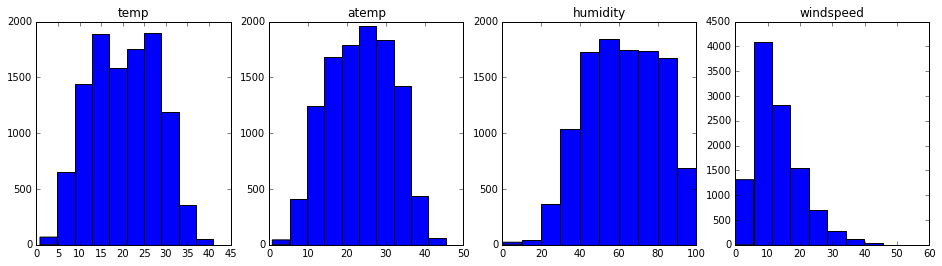

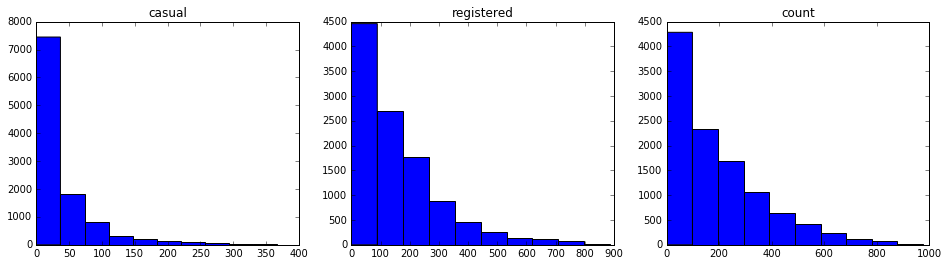

In [3]:
# Training data histogram
fig, axes = plt.subplots(nrows=1, ncols=4, sharex=False, sharey=False, figsize = (16, 4))

for ii in np.arange(1, 5):
    ax = axes[ii-1]
    ax.hist([int(val) for val in train_data[:,ii]]) 
    ax.set_title(train_labels[0][ii])

plt.show()

fig, axes = plt.subplots(nrows=1, ncols=4, sharex=False, sharey=False, figsize = (16, 4))
for ii in np.arange(5, 9):
    ax = axes[ii-5]
    ax.hist([float(val) for val in train_data[:,ii]]) 
    ax.set_title(train_labels[0][ii])

plt.show()

fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize = (16, 4))
for ii in np.arange(9, 12):
    ax = axes[ii-9]
    ax.hist([float(val) for val in train_data[:,ii]]) 
    ax.set_title(train_labels[0][ii])

plt.show()

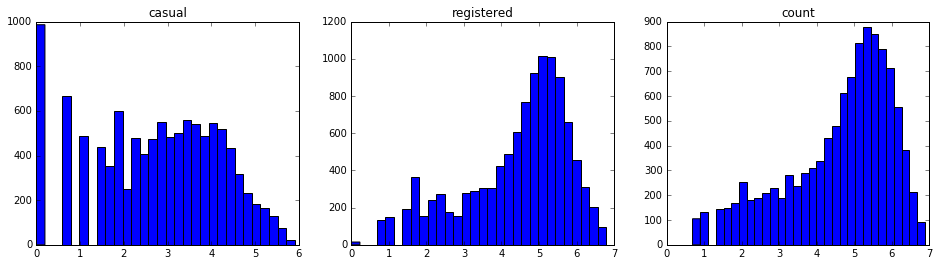

In [116]:
# Looking at the plots, it looks like causal and registers are providing more granualar details for prediction rather than just predicting
# count directly.
# The atemp and temp seem to be highly correlated intutively (so only one parameter is needed)
# Looking at the temp and atemp it looks like binning will help as the count for bins is pretry high.  So intitutively what this means is
# a difference of 1 or 2 * in the temperature will not make a big difference in people renting bikes
# So we can convert the temp from raw values to bucket values
# We can do the same binning for humidity and windspeed
# The casual and registered donot look normal.  Lets see if log will work to make them look normal

from math import exp, expm1, log

log_output_vars = np.empty( (train_data.shape[0], 3 ))

for i in range (0, train_data.shape[0]):
    log_output_vars[i][0] = log( float(train_data[i][9])+1 ) 
    log_output_vars[i][1] = log( float(train_data[i][10])+1 ) 
    log_output_vars[i][2] = log( float(train_data[i][11])+1 )

fig, axes = plt.subplots(nrows=1, ncols=3, sharex=False, sharey=False, figsize = (16, 4))
for ii in np.arange(0, 3):
    ax = axes[ii]
    ax.hist([val for val in log_output_vars[:,ii]], bins=30) 
    ax.set_title(train_labels[0][9+ii])

#plt.show()

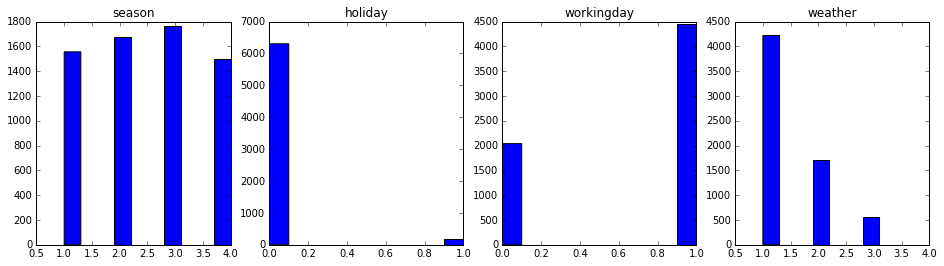

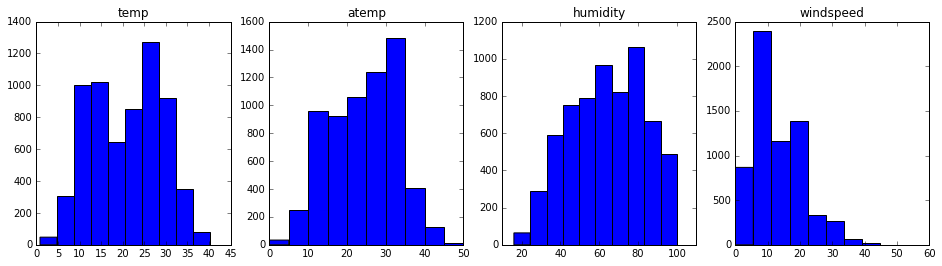

In [4]:
# Test data histogram
fig, axes = plt.subplots(nrows=1, ncols=4, sharex=False, sharey=False, figsize = (16, 4))

for ii in np.arange(1, 5):
    ax = axes[ii-1]
    ax.hist([int(val) for val in test_data[:,ii]]) 
    ax.set_title(test_labels[0][ii])

plt.show()

fig, axes = plt.subplots(nrows=1, ncols=4, sharex=False, sharey=False, figsize = (16, 4))
for ii in np.arange(5, 9):
    ax = axes[ii-5]
    ax.hist([float(val) for val in test_data[:,ii]]) 
    ax.set_title(test_labels[0][ii])

plt.show()

In [75]:
lr = LinearRegression(fit_intercept=True)
# Count is the output for which the input is trained
lr.fit(new_train_data, new_output_data) 
lr_preds = lr.predict(new_test_data)

test_lab_f = open("linear_labeled.csv", "w") # you will need to edit this directory

test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

idx = 0
                 
for pp in lr_preds:    
    test_lab_f.write("\n")
    if ( pp < 0.0 ):
        pp = 0.0
    test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
    idx += 1
   

test_lab_f.close()

# The score returned was 1.43455

In [76]:
# It looks like temp and atemp seems to be the same.  Lets try linear model by removing one at a time to see the score
# Remove temp first
mod_train_data = np.delete(new_train_data, np.s_[4], axis=1)
mod_train_labels = np.delete(new_train_labels, np.s_[4], axis=1)
mod_test_data = np.delete(new_test_data, np.s_[4], axis=1)
mod_test_labels = np.delete(new_test_labels, np.s_[4], axis=1)

lr = LinearRegression(fit_intercept=True)
lr.fit(mod_train_data, new_output_data) 
lr_preds = lr.predict(mod_test_data)


test_lab_f = open("linear_labeled_ntemp.csv", "w") # you will need to edit this directory

test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

idx = 0
                 
for pp in lr_preds:    
    test_lab_f.write("\n")
    if ( pp < 0.0 ):
        pp = 0.0
    test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
    idx += 1
   

test_lab_f.close()

# The score was 1.43445


# Remove atemp 
mod_train_data = np.delete(new_train_data, np.s_[5], axis=1)
mod_train_labels = np.delete(new_train_labels, np.s_[5], axis=1)
mod_test_data = np.delete(new_test_data, np.s_[5], axis=1)
mod_test_labels = np.delete(new_test_labels, np.s_[5], axis=1)

lr = LinearRegression(fit_intercept=True)
# Count is the output for which the input is trained
lr.fit(mod_train_data, new_output_data) 
lr_preds = lr.predict(mod_test_data)

test_lab_f = open("linear_labeled_natemp.csv", "w") # you will need to edit this directory

test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

idx = 0
                 
for pp in lr_preds:    
    test_lab_f.write("\n")
    if ( pp < 0.0 ):
        pp = 0.0
    test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
    idx += 1
   

test_lab_f.close()

# The score was 1.42884 

# Removing atemp improved the score.  Removing the temp did not make any change to the score.

# So we will go with data without atemp

In [77]:
kn = KNeighborsClassifier(n_neighbors=1)

kn.fit(new_train_data, new_output_data)
kn.preds = kn.predict(new_test_data)
#print 'K-Neighbors Prediction'
#print kn.preds

test_lab_f = open("kneigh_labeled.csv", "w") # you will need to edit this directory

test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

idx = 0
                 
for pp in kn.preds:    
    test_lab_f.write("\n")
    test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
    idx += 1
   

test_lab_f.close()

# Score is 1.66165

# Now lets try with the data that got us the lowest linear regresion score
kn = KNeighborsClassifier(n_neighbors=1)

kn.fit(mod_train_data, new_output_data)
kn.preds = kn.predict(mod_test_data)
#print 'K-Neighbors Prediction'
#print kn.preds

test_lab_f = open("kneigh_labeled_natemp.csv", "w") # you will need to edit this directory

test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

idx = 0
                 
for pp in kn.preds:    
    test_lab_f.write("\n")
    test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
    idx += 1
   

test_lab_f.close()
# Score is 1.6585

# Now lets vary the n_neightbors

for i in range(2, 4):
    kn = KNeighborsClassifier(n_neighbors=i)

    kn.fit(mod_train_data, new_output_data)
    kn.preds = kn.predict(mod_test_data)


    test_lab_f = open("kneigh_labeled_natemp_"+str(i)+".csv","w")

    test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

    idx = 0
                     
    for pp in kn.preds:    
        test_lab_f.write("\n")
        test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
        idx += 1
   

    test_lab_f.close()  
    
# Neighbors=2, Score 1.76267
# Neighbors=3, Score 1.90713
# The score increases.  So increasing the neighbors not a good idea
    

In [45]:
# Now we are going to instrument the date and time 
# Then run the linear regression, kneighbors and random-forest
from datetime import datetime

inst_array = np.empty( (train_data.shape[0], 4) )

for i in range (0, train_data.shape[0]):
    date = datetime.strptime(train_data[i][0], "%Y-%m-%d %H:%M:%S")
    inst_array[i][0] = date.weekday()
    inst_array[i][1] = date.hour
    inst_array[i][2] = date.minute
    inst_array[i][3] = date.second

instrument_train_array = np.concatenate( (inst_array, new_train_data), axis = 1 )

inst_array = np.empty( (test_data.shape[0], 4) )

for i in range (0, test_data.shape[0]):
    date = datetime.strptime(test_data[i][0], "%Y-%m-%d %H:%M:%S")
    inst_array[i][0] = date.weekday()
    inst_array[i][1] = date.hour
    inst_array[i][2] = date.minute
    inst_array[i][3] = date.second    

instrument_test_array = np.concatenate( (inst_array, new_test_data), axis = 1 )


lr = LinearRegression(fit_intercept=True)
lr.fit(instrument_train_array, new_output_data) 
lr_preds = lr.predict(instrument_test_array)


test_lab_f = open("linear_labeled_instrument.csv", "w") # you will need to edit this directory

test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

idx = 0
                 
for pp in lr_preds:    
    test_lab_f.write("\n")
    if ( pp < 0.0 ):
        pp = 0.0
    test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
    idx += 1
   

test_lab_f.close()

# The score returned was 1.26685

kn = KNeighborsClassifier(n_neighbors=1)

kn.fit(instrument_train_array, new_output_data)
kn.preds = kn.predict(instrument_test_array)

test_lab_f = open("kneigh_labeled_instrument.csv", "w") # you will need to edit this directory

test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

idx = 0
                 
for pp in kn.preds:    
    test_lab_f.write("\n")
    test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
    idx += 1
   

test_lab_f.close()

# test score 0.94964

rf = RandomForestClassifier()

# Train the model
clf = rf.fit(instrument_train_array, new_output_data)
results = clf.predict(instrument_test_array)


test_lab_f = open("rf_vanilla.csv", "w") # you will need to edit this directory

test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

idx = 0
                 
for pp in results:    
    test_lab_f.write("\n")
    test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
    idx += 1
   

test_lab_f.close()

# Get the probablistic results

results_prob = clf.predict_proba(instrument_train_array)

print(results_prob.shape)
# Set random seed for repeatable results

np.random.seed(12345)

# Change the number of trees to 100 and get the OutOfBag error

rf_100 = RandomForestClassifier(n_estimators=100, oob_score=True)
clf_100 = rf_100.fit(instrument_train_array, new_output_data)
oob_score =  clf_100.oob_score_

print("Out of Bag error")
print(oob_score)

# Limit the trees by number of splits, minimum size to split and minimum leaf size to keep a split
rf_min = RandomForestClassifier(max_depth=5,min_samples_split=6,min_samples_leaf=3)
clf_min = rf_min.fit(instrument_train_array, new_output_data)
results_min = clf_min.predict(instrument_test_array)

print(results_min.shape)

test_lab_f = open("rf_min.csv", "w") # you will need to edit this directory

test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

idx = 0
                 
for pp in results_min:    
    test_lab_f.write("\n")
    test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
    idx += 1
   

test_lab_f.close()

# Set maximum features / maximum percentages of features to examine for split
rf_max = RandomForestClassifier(max_features=1)
clf_max = rf_max.fit(instrument_train_array, new_output_data)
results_max = clf_max.predict(instrument_test_array)

print(results_max.shape)

test_lab_f = open("rf_max.csv", "w") # you will need to edit this directory

test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

idx = 0
                 
for pp in results_max:    
    test_lab_f.write("\n")
    test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
    idx += 1
   

test_lab_f.close()

# Test score rf vanilla = 0.88612
# Test score rf max = 1.20269
# Test score rf min = 1.59555

(10886L, 822L)
Out of Bag error
0.0218629432298
(6493L,)
(6493L,)


In [46]:
# Remove atemp as we have determined before that removing atemp makes score better
mod_instrument_train_data = np.delete(instrument_train_array, np.s_[9], axis=1)
mod_instrument_test_data = np.delete(instrument_test_array, np.s_[9], axis=1)

lr = LinearRegression(fit_intercept=True)
# Count is the output for which the input is trained
lr.fit(mod_instrument_train_data, new_output_data) 
lr_preds = lr.predict(mod_instrument_test_data)
#print lr_preds

test_lab_f = open("linear_labeled_natemp_instrument.csv", "w") # you will need to edit this directory

test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

idx = 0
                 
for pp in lr_preds:    
    test_lab_f.write("\n")
    if ( pp < 0.0 ):
        pp = 0.0
    test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
    idx += 1
   

test_lab_f.close()

# The score was 1.26607 

kn = KNeighborsClassifier(n_neighbors=1)

kn.fit(mod_instrument_train_data, new_output_data)
kn.preds = kn.predict(mod_instrument_test_data)

test_lab_f = open("kneigh_labeled_natemp_instrument.csv", "w") # you will need to edit this directory

test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

idx = 0
                 
for pp in kn.preds:    
    test_lab_f.write("\n")
    test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
    idx += 1
   

test_lab_f.close()

# test score 0.91618
np.random.seed(415)

rf = RandomForestClassifier()

# Train the model
clf = rf.fit(mod_instrument_train_data, new_output_data)
results = clf.predict(mod_instrument_test_data)


test_lab_f = open("rf_vanilla_natemp.csv", "w") # you will need to edit this directory

test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

idx = 0
                 
for pp in results:    
    test_lab_f.write("\n")
    test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
    idx += 1
   

test_lab_f.close()

# Test score rf vanilla = 0.88345

In [33]:
# Instead of predicting count, predict registered and casual.  Then add them to predict the count
registered_output_data = conv_train_data[:, conv_train_data.shape[1]-2]
casual_output_data = conv_train_data[:, conv_train_data.shape[1]-3]


np.random.seed(415)

rf = RandomForestClassifier()

# Train the model
clf = rf.fit(instrument_train_array, registered_output_data)
results_registered = clf.predict(instrument_test_array)

clf = rf.fit(instrument_train_array, casual_output_data)
casual_registered = clf.predict(instrument_test_array)

results = np.add(results_registered, casual_registered)
test_lab_f = open("rf_split.csv", "w") 

test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

idx = 0
                 
for pp in results:    
    test_lab_f.write("\n") 
    test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
    idx += 1
   

test_lab_f.close()

# Score 0.82563

# Now do the same without atemp to conclude we dont need atemp
np.random.seed(415)

rf = RandomForestClassifier()

# Train the model
clf = rf.fit(mod_instrument_train_data, registered_output_data)
results_registered = clf.predict(mod_instrument_test_data)

clf = rf.fit(mod_instrument_train_data, casual_output_data)
casual_registered = clf.predict(mod_instrument_test_data)

results = np.add(results_registered, casual_registered)
test_lab_f = open("rf_split_natemp.csv", "w") 

test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

idx = 0
                 
for pp in results:    
    test_lab_f.write("\n") 
    test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
    idx += 1
   

test_lab_f.close()
# Score 0.78115

# We have better score without atemp.  So we are going to proceed without atemp 

In [48]:
bin_train_data[:] = mod_instrument_train_data
bin_test_data[:] = mod_instrument_test_data
# Based on the histogram it looks like we can bin the temp into 6 or 7 bins
train_temp_bin = np.empty( bin_train_data.shape[0] )
for i in range(0, bin_train_data.shape[0]):
    if ( bin_train_data[i][8] < 1.0* 5):
        train_temp_bin[i] = 0 ;
    elif ( bin_train_data[i][8] < 1.0* 10):
        train_temp_bin[i] = 1 ;
    elif ( bin_train_data[i][8] < 1.0 * 15):
        train_temp_bin[i] = 2 ;
    elif ( bin_train_data[i][8] < 1.0 * 20):
        train_temp_bin[i] = 3 ;
    elif ( bin_train_data[i][8] < 1.0 * 25):
        train_temp_bin[i] = 4 ;        
    elif ( bin_train_data[i][8] < 1.0 * 30):
        train_temp_bin[i] = 5 ;
    elif ( bin_train_data[i][8] < 1.0 * 35):
        train_temp_bin[i] = 6 ;    
    elif ( bin_train_data[i][8] < 1.0* 40):
        train_temp_bin[i] = 7 ;
    else:
        train_temp_bin[i] = 8 ;  
# Now replace temp with the binning value in the instrumented array
bin_train_data[:,8] = train_temp_bin

# Do the same for humditity
train_humid_bin = np.empty( bin_train_data.shape[0] )
for i in range(0, bin_train_data.shape[0]):
    if ( bin_train_data[i][9] < 1.0* 10):
        train_humid_bin[i] = 0 ;
    elif ( bin_train_data[i][9] < 1.0* 20):
        train_humid_bin[i] = 1 ;
    elif ( bin_train_data[i][9] < 1.0 * 30):
        train_humid_bin[i] = 2 ;
    elif ( bin_train_data[i][9] < 1.0 * 40):
        train_humid_bin[i] = 3 ;
    elif ( bin_train_data[i][9] < 1.0 * 50):
        train_humid_bin[i] = 4 ;        
    elif ( bin_train_data[i][9] < 1.0 * 60):
        train_humid_bin[i] = 5 ;
    elif ( bin_train_data[i][9] < 1.0 * 70):
        train_humid_bin[i] = 6 ;    
    elif ( bin_train_data[i][9] < 1.0* 80):
        train_humid_bin[i] = 7 ;
    elif ( bin_train_data[i][9] < 1.0* 90):
        train_humid_bin[i] = 8 ;
    else:
        train_humid_bin[i] = 9 ;  
# Now replace humidity with the binning value in the instrumented array
bin_train_data[:,9] = train_humid_bin

# Do the same for windspeed
train_wind_bin = np.empty( bin_train_data.shape[0] )
for i in range(0, bin_train_data.shape[0]):
    if ( bin_train_data[i][10] < 1.0* 10):
        train_wind_bin[i] = 0 ;
    elif ( bin_train_data[i][10] < 1.0* 20):
        train_wind_bin[i] = 1 ;
    elif ( bin_train_data[i][10] < 1.0 * 30):
        train_wind_bin[i] = 2 ;
    elif ( bin_train_data[i][10] < 1.0 * 40):
        train_wind_bin[i] = 3 ;
    elif ( bin_train_data[i][10] < 1.0 * 50):
        train_wind_bin[i] = 4 ;        
    elif ( bin_train_data[i][10] < 1.0 * 60):
        train_wind_bin[i] = 5 ;
    elif ( bin_train_data[i][10] < 1.0 * 70):
        train_wind_bin[i] = 6 ;    
    elif ( bin_train_data[i][10] < 1.0* 80):
        train_wind_bin[i] = 7 ;
    elif ( bin_train_data[i][10] < 1.0* 90):
        train_wind_bin[i] = 8 ;
    else:
        train_wind_bin[i] = 9 ;  
# Now replace humidity with the binning value in the instrumented array
bin_train_data[:,10] = train_wind_bin

test_temp_bin = np.empty( bin_test_data.shape[0] )
for i in range(0, bin_test_data.shape[0]):
    if ( bin_test_data[i][8] < 1.0* 5):
        test_temp_bin[i] = 0 ;
    elif ( bin_test_data[i][8] < 1.0* 10):
        test_temp_bin[i] = 1 ;
    elif ( bin_test_data[i][8] < 1.0 * 15):
        test_temp_bin[i] = 2 ;
    elif ( bin_test_data[i][8] < 1.0 * 20):
        test_temp_bin[i] = 3 ;
    elif ( bin_test_data[i][8] < 1.0 * 25):
        test_temp_bin[i] = 4 ;        
    elif ( bin_test_data[i][8] < 1.0 * 30):
        test_temp_bin[i] = 5 ;
    elif ( bin_test_data[i][8] < 1.0 * 35):
        test_temp_bin[i] = 6 ;    
    elif ( bin_test_data[i][8] < 1.0* 40):
        test_temp_bin[i] = 7 ;
    else:
        test_temp_bin[i] = 8 ;  
# Now replace temp with the binning value in the instrumented array
bin_test_data[:,8] = test_temp_bin

# Do the same for humditity
test_humid_bin = np.empty( bin_test_data.shape[0] )
for i in range(0, bin_test_data.shape[0]):
    if ( bin_test_data[i][9] < 1.0* 10):
        test_humid_bin[i] = 0 ;
    elif ( bin_test_data[i][9] < 1.0* 20):
        test_humid_bin[i] = 1 ;
    elif ( bin_test_data[i][9] < 1.0 * 30):
        test_humid_bin[i] = 2 ;
    elif ( bin_test_data[i][9] < 1.0 * 40):
        test_humid_bin[i] = 3 ;
    elif ( bin_test_data[i][9] < 1.0 * 50):
        test_humid_bin[i] = 4 ;        
    elif ( bin_test_data[i][9] < 1.0 * 60):
        test_humid_bin[i] = 5 ;
    elif ( bin_test_data[i][9] < 1.0 * 70):
        test_humid_bin[i] = 6 ;    
    elif ( bin_test_data[i][9] < 1.0* 80):
        test_humid_bin[i] = 7 ;
    elif ( bin_test_data[i][9] < 1.0* 90):
        test_humid_bin[i] = 8 ;
    else:
        test_humid_bin[i] = 9 ;  
# Now replace humidity with the binning value in the instrumented array
bin_test_data[:,9] = test_humid_bin

# Do the same for windspeed
test_wind_bin = np.empty( bin_test_data.shape[0] )
for i in range(0, bin_test_data.shape[0]):
    if ( bin_test_data[i][10] < 1.0* 10):
        test_wind_bin[i] = 0 ;
    elif ( bin_test_data[i][10] < 1.0* 20):
        test_wind_bin[i] = 1 ;
    elif ( bin_test_data[i][10] < 1.0 * 30):
        test_wind_bin[i] = 2 ;
    elif ( bin_test_data[i][10] < 1.0 * 40):
        test_wind_bin[i] = 3 ;
    elif ( bin_test_data[i][10] < 1.0 * 50):
        test_wind_bin[i] = 4 ;        
    elif ( bin_test_data[i][10] < 1.0 * 60):
        test_wind_bin[i] = 5 ;
    elif ( bin_test_data[i][10] < 1.0 * 70):
        test_wind_bin[i] = 6 ;    
    elif ( bin_test_data[i][10] < 1.0* 80):
        test_wind_bin[i] = 7 ;
    elif ( bin_test_data[i][10] < 1.0* 90):
        test_wind_bin[i] = 8 ;
    else:
        test_wind_bin[i] = 9 ;  
# Now replace windspeed with the binning value in the instrumented array
bin_test_data[:,10] = test_wind_bin

In [51]:
# Now run the RCLF

np.random.seed(415)

rf = RandomForestClassifier()

# Train the model
clf = rf.fit(bin_train_data, registered_output_data)
results_registered = clf.predict(bin_test_data)

clf = rf.fit(bin_train_data, casual_output_data)
casual_registered = clf.predict(bin_test_data)

results = np.add(results_registered, casual_registered)
test_lab_f = open("rf_bin_temp.csv", "w") 

test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

idx = 0
                 
for pp in results:    
    test_lab_f.write("\n") 
    test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
    idx += 1
   

test_lab_f.close()
# Score 0.67546 


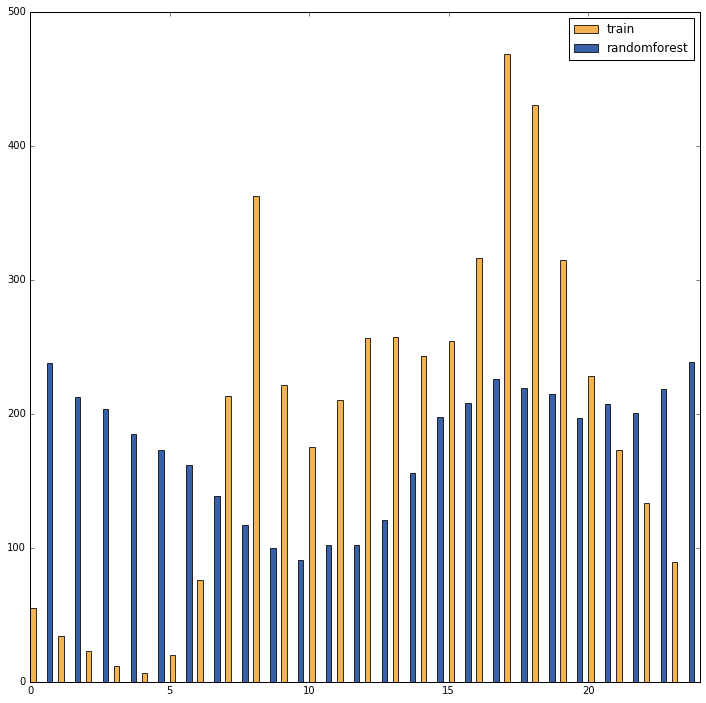

In [129]:
#create new variable for hour
hour = np.zeros(train_data.shape[0])

for i in range(train_data[:,0].shape[0]):
    date = datetime.strptime(train_data[i][0], "%Y-%m-%d %H:%M:%S")
    hour[i] = date.hour

#define a function to 'roll up' data (like excel pivot table)    
def summarize(preds):
    averages = np.empty([24,])
    for i in range(24):
        count = 0
        n = 0
        for h in range(preds.shape[0]):
            if hour[h] == i:
                count += preds[h]
                n += 1
        averages[i] = count/n
    return averages


plt.figure(figsize=(12,12))
plt.xlim(0,24)
bar_width = 0.2
opacity = 0.8

def width_adjust(x):
    x_adjust = []    
    for i in range(24):
        x_adjust.append(hour[i] + x)
    return x_adjust

bars_train = plt.bar(set(hour), summarize(new_output_data), bar_width,
                 alpha=opacity,
                 color='#efa028',
                 label='train')

bars_rf = plt.bar(width_adjust(3*bar_width), summarize(results), bar_width,
                 alpha=opacity,
                 color='#073a93',
                 label='randomforest')

plt.legend()



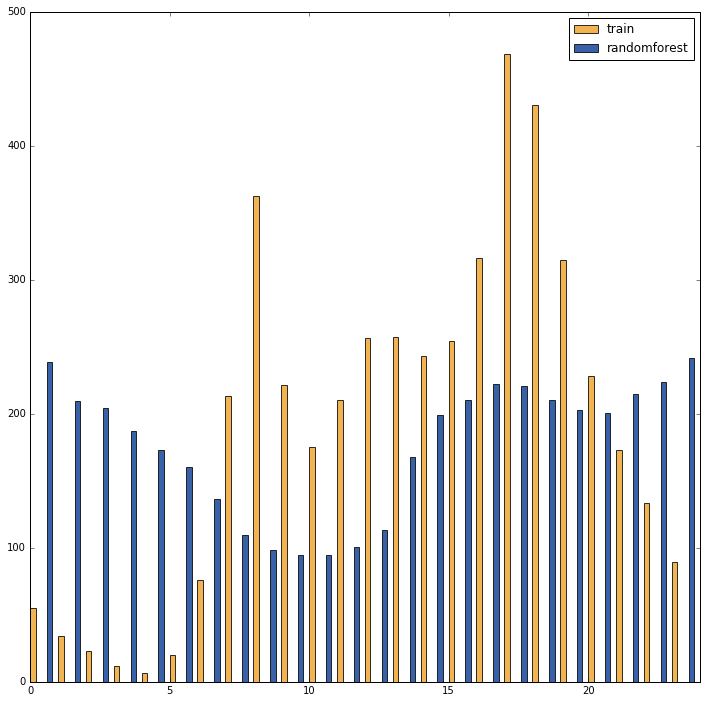

In [131]:
# When loking at the holiday vs working it is not very apparent what is the weekend effect as intution says weekend will have more count than
# weekday.  So lets instrument that as well
week_train_data = np.empty( (bin_train_data.shape[0], bin_train_data.shape[1]+1))
weekend_train = np.empty( (bin_train_data.shape[0], 1 ))
for i in range(0, bin_train_data.shape[0]):
    if ( bin_train_data[i][0] > 4 ):
        weekend_train[i] = 1 ;
    else:
        weekend_train[i] = 0 ;

week_train_data = np.concatenate( (bin_train_data, weekend_train), axis = 1 )


week_test_data = np.empty( (bin_test_data.shape[0], bin_test_data.shape[1]+1))
weekend_test = np.empty( (bin_test_data.shape[0], 1) )
for i in range(0, bin_test_data.shape[0]):
    if ( bin_test_data[i][0] > 4 ):
        weekend_test[i] = 1 ;
    else:
        weekend_test[i] = 0 ;
        
week_test_data = np.concatenate( (bin_test_data, weekend_test), axis = 1 )

# Now run the RCLF

np.random.seed(415)

rf = RandomForestClassifier()

clf = rf.fit(week_train_data, casual_output_data)
casual_registered = clf.predict(week_test_data)

clf = rf.fit(week_train_data, registered_output_data)
results_registered = clf.predict(week_test_data)

results = np.add(results_registered, casual_registered)
test_lab_f = open("rf_week_temp.csv", "w") 

test_lab_f.write(str(test_labels[0,0]) + "," + str(train_labels[0, -1]))

idx = 0
                 
for pp in results:    
    test_lab_f.write("\n") 
    test_lab_f.write(str(test_data[:,0][idx]) + "," + str(int(pp)))
    idx += 1
   

test_lab_f.close()
# Score 0.65737 

#create new variable for hour
hour = np.zeros(train_data.shape[0])

for i in range(train_data[:,0].shape[0]):
    date = datetime.strptime(train_data[i][0], "%Y-%m-%d %H:%M:%S")
    hour[i] = date.hour

#define a function to 'roll up' data (like excel pivot table)    
def summarize(preds):
    averages = np.empty([24,])
    for i in range(24):
        count = 0
        n = 0
        for h in range(preds.shape[0]):
            if hour[h] == i:
                count += preds[h]
                n += 1
        averages[i] = count/n
    return averages


plt.figure(figsize=(12,12))
plt.xlim(0,24)
bar_width = 0.2
opacity = 0.8

def width_adjust(x):
    x_adjust = []    
    for i in range(24):
        x_adjust.append(hour[i] + x)
    return x_adjust

bars_train = plt.bar(set(hour), summarize(new_output_data), bar_width,
                 alpha=opacity,
                 color='#efa028',
                 label='train')

bars_rf = plt.bar(width_adjust(3*bar_width), summarize(results), bar_width,
                 alpha=opacity,
                 color='#073a93',
                 label='randomforest')

plt.legend()



In [126]:
# It is getting more clear that during the mid-day the prediction follows the train data shape.  But 
# during the early and late hours the trend between the training and predicted is way off

(10886L,)

In [119]:
casual_output_data.shape



(10886L,)